In [8]:
import pandas as pd
import numpy as np
import magic
from matplotlib import pyplot as plt
import importlib
%matplotlib inline
importlib.reload(magic)
import seaborn as sns
from xgboost import XGBClassifier


In [2]:
csv_file = 'future'
data = pd.read_csv(csv_file)
data['tournament'] = data.tournament_scores/data.num_players
data['effectiveness'] = np.log(data.scores+1)/np.log(data.map_rivers_count/data.num_players)
data['density'] = np.log(data.map_rivers_count)/np.log(data.map_sites_count)


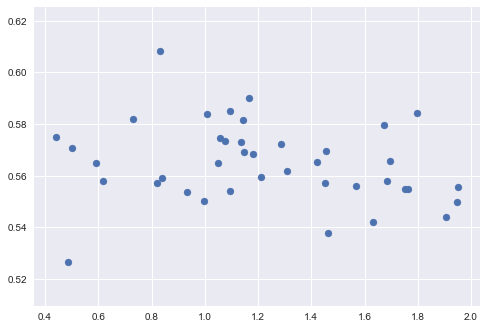

In [3]:
t = data.loc[data.map=='boston-sparse.json']
t = data.groupby('name').mean()[['tournament','param1','effectiveness']]
plt.scatter(t.param1,t.tournament)


In [4]:
numparams = 1
params = ['param' + str(i) for i in range(1,numparams+1)]

test = data.loc[:  , ['game_number','ranking']+params]
test = pd.merge(left=test,right=test,left_on='game_number',right_on='game_number',how='inner')
test = test.loc[test.ranking_x!=test.ranking_y]
test['x_wins'] = np.where(test.ranking_x<test.ranking_y,1,0)

features = [p+"_"+l for p in params for l in ['x','y']]


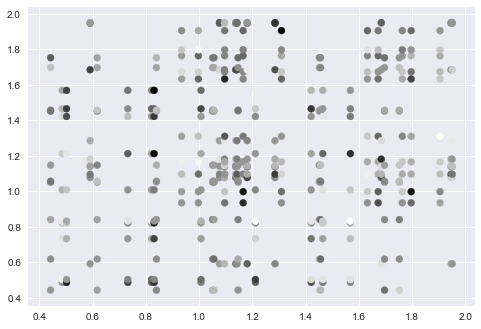

In [6]:
grs = test.groupby(['param1_x','param1_y']).mean()['x_wins'].reset_index()
plt.scatter(grs.param1_x,grs.param1_y,c=grs.x_wins)

In [9]:
model = XGBClassifier()
model.fit(test[features],test.x_wins)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [10]:
list(zip(features,model.feature_importances_))


[('param1_x', 0.49782294), ('param1_y', 0.50217706)]

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(),test[features],test.x_wins)

array([ 0.50248933,  0.50320057,  0.49727952])